# Example: MAST-U Control Room GUI Preparation

This example notebook follows on from the previous notebook. 

Here, we test out loading the default MAST-U plasma flux guess and then solve for an equilibrium from a different shot/time at a different spatial resolution.

In [1]:
# changes working directory (comment out if not needed)
import os
os.chdir("freegsnke/examples") 
print(os.getcwd())

/home/kpentlan/Documents/freegsnke/examples


In [2]:
import numpy as np
import pickle
import time
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

# freegs4e/freegsnke modules (other may be needed later)
import freegs4e
from freegsnke import equilibrium_update, GSstaticsolver

# module containing various functions for pulling UDA data
from helper_functions.pull_UDA_data import *

In [3]:
# MAST-U shot number (make sure it's a valid shot with EFIT++ equilibrium reconstruction data!)
shot = 45425

## Build the MAST-U machine

Next, we build the MAST-U machine object. This can be done using the geometry data from a particular shot number via the 'get_machine_data' function below.

FreeGSNKE requires the following envirnoment variables in order to build the machine: ACTIVE_COILS_PATH, PASSIVE_COILS_PATH, WALL_PATH, LIMITER_PATH, PROBE_PATH. 

Note 1: There are two options used for building the active coils in FreeGSNKE. The first sets up **symmetric** coils where the corresponding up/down coils in MAST-U (e.g. P4_upper and P4_lower) are wired **in series** and therefore will be assigned the same current value later. The second option sets up **non-symmetric** coils in which the up/down coils are modelled independently and can be assigned **different** currents (i.e. they are **not wired in series**). Set the 'symmetric_machine' parameter to either 'True' or 'False' to toggle this setting. We use the **non-symmetric** setting here as the coil currents in EFIT++ are calculated independently (though you may test out the symmetric case too to see the differences). 

Note 2: The magnetic probes are not used in this script (see "example1c" for how to use them). 

In [4]:
# This function will pull machine geoemtry data from the shot number.
# 'split_passive=True' means the passives structures will be modelled as parallelograms with current
# distributed evenly over their cross-sectional area (which is reccomended), setting to 'False' will
# model them as point sources (less accurate for parallelograms with large surface areas).
get_machine_data(shot=shot, split_passives=True)

MAST-U geometry data successfully extracted and pickle files built.


In [5]:
# set paths (choose symmetric or non-symmetric active coils)
symmetric_machine = True
if symmetric_machine:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils.pickle"
else:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils_nonsym.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_limiter.pickle"
os.environ["PROBE_PATH"] = f"../machine_configs/MAST-U/MAST-U_magnetic_probes.pickle"

# now the machine can actually be built
from freegsnke import build_machine
tokamak = build_machine.tokamak()

## Load the required input data from the EFIT++ reconstructions
Here, we load the parameters required by the static forward GS solver (at each independent EFIT++ time step). They include the:
 - plasma current ($I_p$).
 - fvac parameter (= $r B_{tor}$).
 - profile function coefficients (alpha, beta - both vectors) and logical parameters (alpha_logic, beta_logic - both Booleans).
 - active coil and passive structure currents (loads currents for both symmetric and non-symmetric active coil setups).
    
Note 1: The function loads values for all time steps in the EFIT++ reconstruction (including time steps that may have failed to converge - we will exclude these later on).

Note 2: For **magnetics-only** EFIT++ reconstructions, the "Lao" polynomials are used to parameterise the pressure and toroidal current density profiles, respectively:

$$
\frac{dp}{d \hat{\psi}} = \sum_{n=0}^{n_p} \alpha_n \hat{\psi}^n - \hat{\alpha} \hat{\psi}^{n_p+1} \sum_{n=0}^{n_p} \alpha_n,
$$

$$
F \frac{dF}{d \hat{\psi}} = \sum_{n=0}^{n_F} \beta_n \hat{\psi}^n - \hat{\beta} \hat{\psi}^{n_F+1} \sum_{n=0}^{n_F} \beta_n.
$$

Where:
-  $\hat{\psi}$ is the normalised flux.
-  $ \alpha = (\alpha_0, \ldots, \alpha_{n_p})$ and $\beta = (\beta, \ldots, \beta{n_F})$ are the profle coefficients.
-  $\hat{\alpha}$ and $\hat{\beta}$ are logical (Boolean) parameters that set the boundary condition for the functions.

Note 3: There is also the option to set the passive structure currents to zero if desired. 

In [6]:
# initialise the pyuda client to access the data
import pyuda
client = pyuda.Client()

# load the parameters
Ip, fvac, alpha, beta, alpha_logic, beta_logic, currents_sym, currents_nonsym, _ = load_static_solver_inputs(
    client=client,        # pyuda client
	shot=shot,            # shot number
	zero_passives=False   # set passive structure currents to zero? (True or False)
    )

We now load the shot times at which the EFIT++ reconstructions were carried out (which correspond to the above data) and check which time slices successfully converged. This is important because we need to exclude those that failed to converge (typically these occur during the ramp-up and ramp-dwn of the plasma). 

In [7]:
# load the efit reconstruction timestamps and convergence status
# Note: efit_times that have efit_status=-1 did not converge so we will exclude those time slices
efit_times, efit_status = load_efit_times_and_status(client=client, shot=shot)

# figure out which time slices did not converge
time_indices = np.where(efit_status == 1)[0]
time_slices_excluded = np.where(efit_status == -1)[0]
print(f"{len(time_slices_excluded)} time slices (out of total {len(efit_times)}) excluded from simulation.")
print(f"The excluded time slices are: {efit_times[time_slices_excluded]} seconds.")

times = efit_times[time_indices]  # these are the slices we simulate
print(f"Total time slices to be simulated: {len(times)}.")


9 time slices (out of total 222) excluded from simulation.
The excluded time slices are: [0.02  0.025 0.035 0.04  0.045 0.05  0.055 0.06  1.135] seconds.
Total time slices to be simulated: 213.


Let us plot some of the input parameters over these times to check they are indeed valid (as we may need to exclude some more if EFIT++ failed to catch the non-convergence).

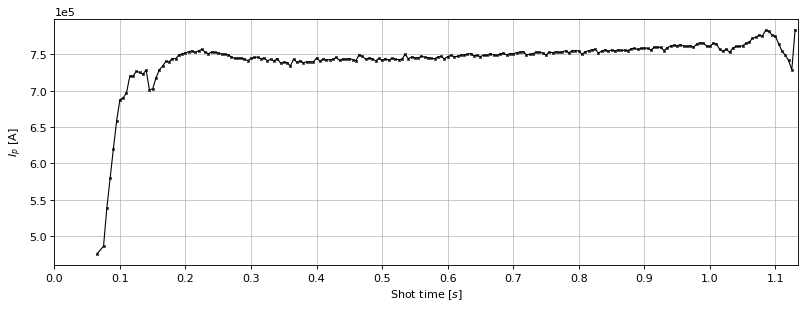

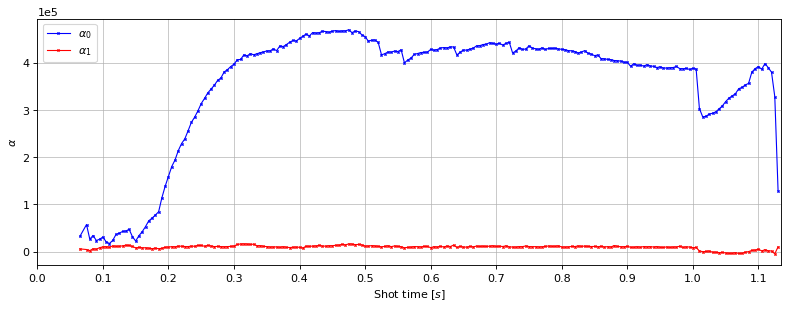

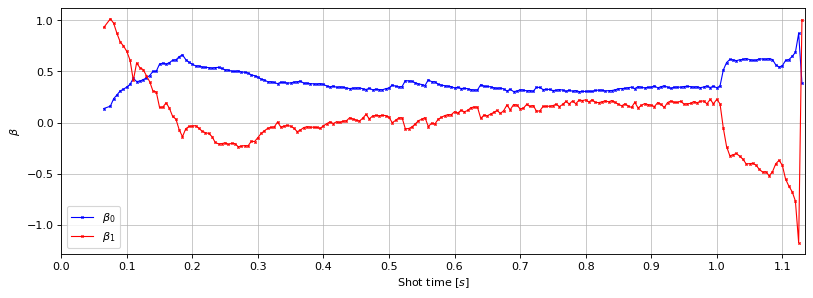

In [8]:
fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(times, Ip[time_indices], color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$I_p$ [A]')
ax1.set_xticks(np.arange(0, times[-1], 0.1))
ax1.set_xlim(0, times[-1] + 0.005)
ax1.ticklabel_format(axis='y', scilimits=(0,0))

fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(times, alpha[time_indices,0], color='b', linewidth=1, marker='x', markersize=2, zorder=10, label=r"$\alpha_0$")
ax1.plot(times, alpha[time_indices,1], color='r', linewidth=1, marker='x', markersize=2, zorder=10, label=r"$\alpha_1$")
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$\alpha$')
ax1.set_xticks(np.arange(0, times[-1], 0.1))
ax1.set_xlim(0, times[-1] + 0.005)
ax1.ticklabel_format(axis='y', scilimits=(0,0))
ax1.legend(loc = "upper left")

fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(times, beta[time_indices,0], color='b', linewidth=1, marker='x', markersize=2, zorder=10, label=r"$\beta_0$")
ax1.plot(times, beta[time_indices,1], color='r', linewidth=1, marker='x', markersize=2, zorder=10, label=r"$\beta_1$")
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$\beta$')
ax1.set_xticks(np.arange(0, times[-1], 0.1))
ax1.set_xlim(0, times[-1] + 0.005)
ax1.ticklabel_format(axis='y', scilimits=(0,0))
ax1.legend(loc = "lower left")

In [9]:
# load the example MAST-U plasma flux initial guess
with open("helper_functions/MAST-U_plasma_flux.pickle", "rb") as f:
   data = pickle.load(f)
data

{'psi_plasma': array([[1.05867351e-06, 1.08189337e-06, 1.10577888e-06, ...,
         1.08926418e-06, 1.06584100e-06, 1.04306786e-06],
        [7.77931735e-06, 7.95015493e-06, 8.12565628e-06, ...,
         8.00431363e-06, 7.83220897e-06, 7.66465346e-06],
        [2.06919261e-05, 2.11458853e-05, 2.16126196e-05, ...,
         2.12899172e-05, 2.08322146e-05, 2.03869825e-05],
        ...,
        [2.21583017e-02, 2.24480444e-02, 2.27419298e-02, ...,
         2.25404006e-02, 2.22493518e-02, 2.19624113e-02],
        [2.22825563e-02, 2.25719512e-02, 2.28654401e-02, ...,
         2.26641942e-02, 2.23735083e-02, 2.20868832e-02],
        [2.24044070e-02, 2.26934104e-02, 2.29864590e-02, ...,
         2.27855262e-02, 2.24952467e-02, 2.22089805e-02]]),
 'Rmin': 0.01,
 'Rmax': 2.2,
 'Zmin': -2.4,
 'Zmax': 2.4}

In [ ]:
# interpolate the plasma psi on the required grid

import scipy as sp

plasma_psi_func = sp.interpolate.RectBivariateSpline(
    np.linspace(data["Rmin"], data["Rmax"], data["psi_plasma"].shape[0]),
    np.linspace(data["Zmin"], data["Zmax"], data["psi_plasma"].shape[1]),
    data["psi_plasma"],
)

# chosen computational boundary
Rmin = 0.06
Rmax = 2.0
Zmin = -2.2
Zmax = 2.2
nx = 65
ny = 65

plasma_psi_guess = plasma_psi_func(np.linspace(Rmin, Rmax, nx), np.linspace(Zmin, Zmax, ny), grid=True)

In [11]:
# equilibrium object (note that both nx and ny have to be of the form 2**n + 1 with n being an integer)
eq = equilibrium_update.Equilibrium(
tokamak=tokamak,             # sets up the object with the MAST-U tokamak
Rmin=Rmin, Rmax=Rmax,         # computational grid radial limits 
Zmin=Zmin, Zmax=Zmax,         # computational grid vertical limits 
nx=65,                       # number of grid points in the radial direction
ny=65,                       # number of grid points in the vertical direction
psi=plasma_psi_guess                     # initial guess for the plasma flux (can provide one if available)
) 

In [12]:
# static solver object (used for solving later on)
solver = GSstaticsolver.NKGSsolver(eq)

## Use FreeGSNKE to solve the static forward GS equation

Choose a time slice to solve for via parameter `i`. 

In [13]:
from freegsnke import jtor_update # for initialising the profile object
from copy import deepcopy

# select time to simulate
i = 76

# initialise profile object
profiles = jtor_update.Lao85(
    eq=eq,                                          # equilibrium object
    limiter=tokamak.limiter,                        # plasma limiter
    Ip=Ip[i],                                       # total plasma current
    fvac=fvac[i],                                   # f vacuum parameter (R*Bt)
    alpha=alpha[i,:],                               # p' profile coefficients
    beta=beta[i,:],                                 # ff' profile coefficients
    alpha_logic=bool(alpha_logic[i]),               # logic parameters from above
    beta_logic=bool(beta_logic[i]),
)

# set coil currents in eq object
# checks if machine is up/down symmetric or not
if symmetric_machine:
    for key in currents_sym.keys():
        eq.tokamak[key].current = currents_sym[key][i]
else:
    for key in currents_nonsym.keys():
        eq.tokamak[key].current = currents_nonsym[key][i]
    
# carry out the forward solve
solver.solve(eq=eq,
                profiles=profiles,
                constrain=None,
                target_relative_tolerance=1e-6,
            )

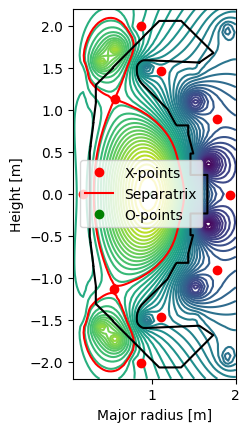

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [14]:
eq.plot()